In [1]:
import os

import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, Normalizer
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

import xgboost
import lightgbm as lgb

import pickle

In [2]:
train_well = pd.read_csv("train1.csv").replace(-999.0000, np.nan)
test_well = pd.read_csv("test1.csv").replace(-999.0000, np.nan)

In [3]:
def grid_plot(col):
    comb = []
    for i in col:
        for j in col:
            comb.append([i,j])

    a,b = len(col), len(col)

    plt.figure(figsize=(5*len(col),5*len(col)))

    for i in range(len(comb)):
        plt.subplot(a,b,i+1)

        plt.xlabel(comb[i][1])
        plt.ylabel(comb[i][0])

        plt.scatter(comb[i][1],comb[i][0], data=train_well, color='red', alpha = 0.1, label='Train Well')

#         plt.legend(loc='upper right')
def grid_dtc_dts(col=['GR', 'CNC', 'ZDEN', 'HRD', 'PE', 'CAL']):
    plt.figure(figsize=(25,10))
    
    for i in range(6):
        plt.subplot(2,6,i+1)
        plt.scatter('DTC', col[i], data=train_well, color='red', alpha = 0.1)
        plt.xlabel('DTC')
        plt.ylabel(col[i])
        
    for i in range(6):
        plt.subplot(2,6,i+7)
        plt.scatter('DTS', col[i], data=train_well, color='red', alpha = 0.1)
        plt.xlabel('DTS')
        plt.ylabel(col[i])
        
def triple_combo(data):
    plt.figure(figsize=(25,25))
    plt.title('TRIPLE COMBO PLOT')

    y_temp = range(data.shape[0])
    
    log = ['CAL','GR', 'CNC', 'ZDEN', 'PE', 'HRD','DTC']
    scale = [[0,35],[0, 250], [-0.15, 0.45], [1.95, 2.95], [0,15], [0.2, 2000], [30,330]]
    
    for i in range(len(log)):
        plt.subplot(171+i)
        plt.plot(log[i], y_temp, data=data)
        plt.xlim(scale[i])
        plt.ylim([0,33000])
        if log[i] == 'DTC':
            plt.plot('DTS', y_temp, data=data, c='red', label='DTC')
            
        elif log[i] == 'HRD':
            plt.plot('HRM', y_temp, data=data, c='red', label='HRM')
            plt.gca().set_xscale('log')

            
        elif log[i] == 'CNC':
            plt.gca().invert_xaxis()
            
        plt.gca().invert_yaxis()
        plt.title(log[i])
        
        
def plot_hist_all(log=False):
    plt.figure(figsize=(15,10))
    
    if log == False:
        for i,j in enumerate(['CNC','ZDEN','GR','HRD','DTC','DTS']):
            plt.subplot(3,3,i+1)
            min_dat = int(np.floor(np.nanpercentile(train_well[j], 3)))
            max_dat = int(np.ceil(np.nanpercentile(train_well[j], 97)))

            plt.hist(j, data=train_well, bins= np.linspace(min_dat, max_dat, 40));
            plt.title(j+ ' Histogram')
    else:
        for i,j in enumerate(['CNC_log','ZDEN_log','GR_log','HRD_log','DTC_log','DTS_log']):
            plt.subplot(3,3,i+1)
            min_dat = int(np.floor(np.nanpercentile(train_well[j], 3)))
            max_dat = int(np.ceil(np.nanpercentile(train_well[j], 97)))

            plt.hist(j, data=train_well, bins= np.linspace(min_dat, max_dat, 40));
            plt.title(j+ ' Histogram')

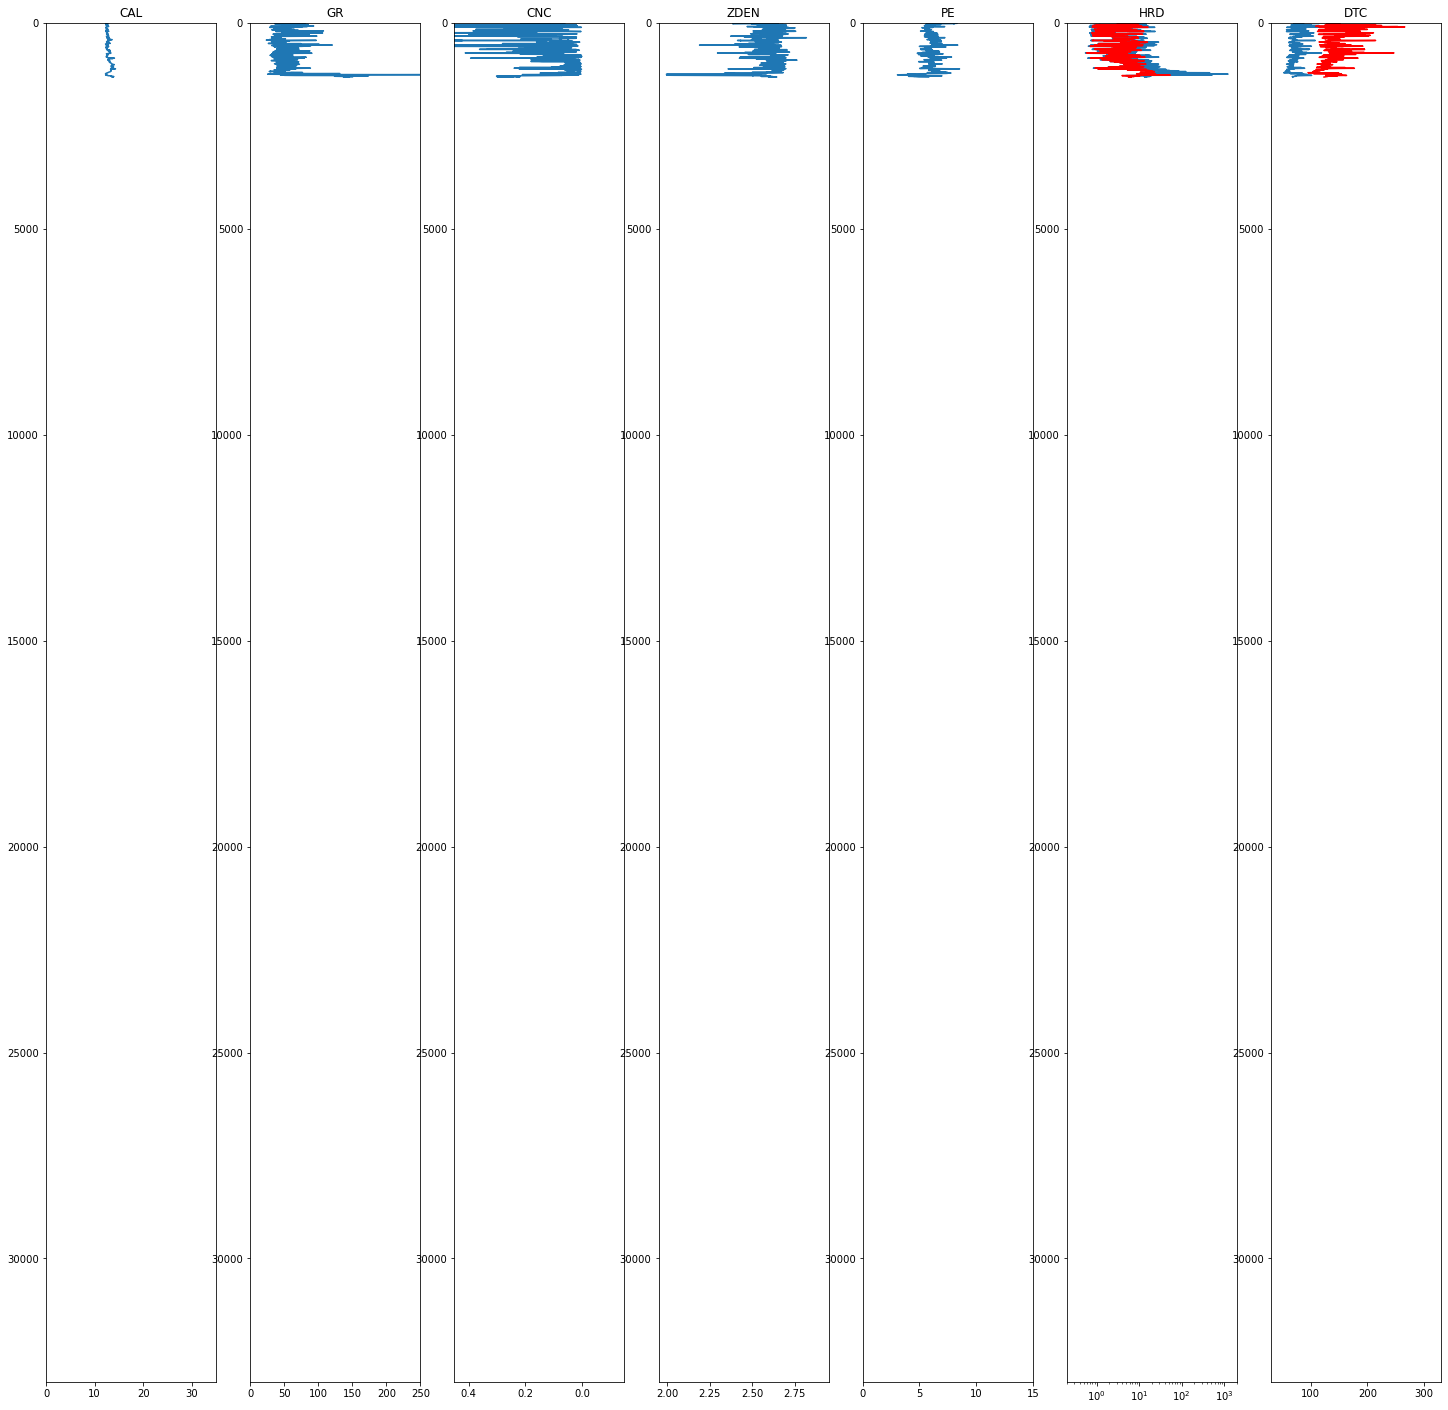

In [4]:
triple_combo(train_well)


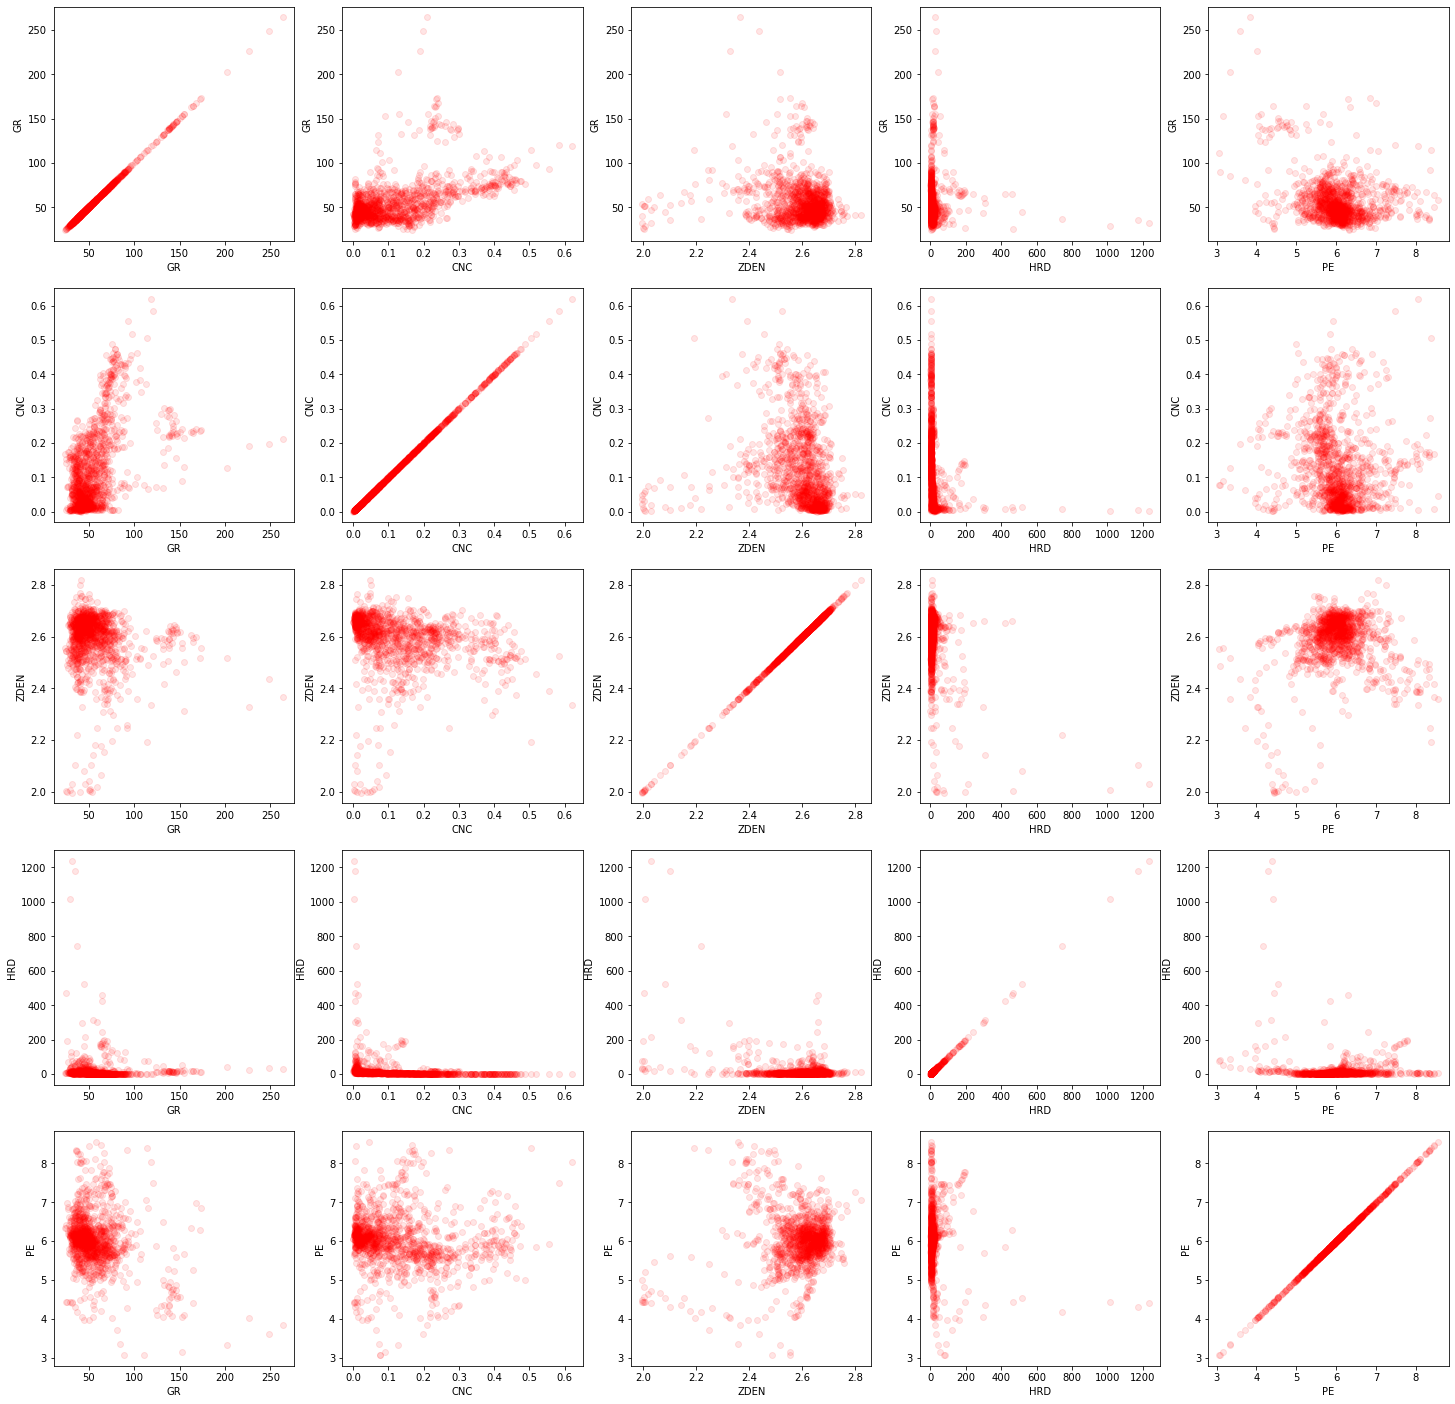

In [5]:
grid_plot(['GR', 'CNC', 'ZDEN', 'HRD', 'PE'])

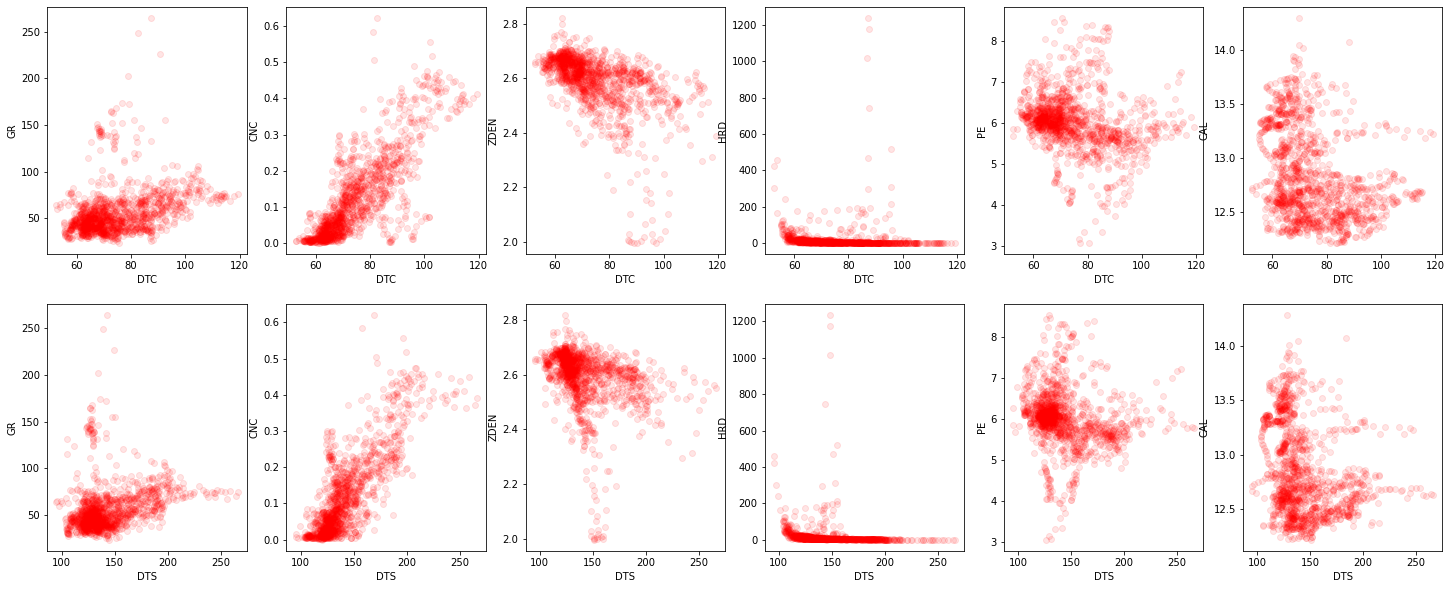

In [6]:
grid_dtc_dts()

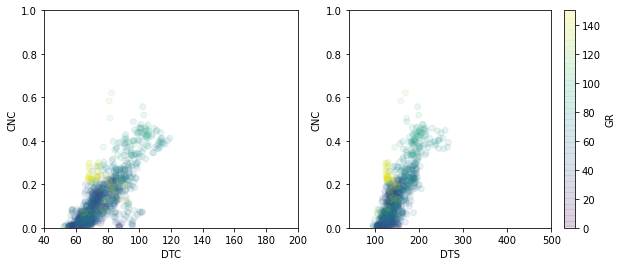

In [7]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter('DTC', 'CNC', data=train_well, alpha=0.1,
           c = 'GR', vmin = 0, vmax= 150)
plt.xlabel('DTC')
plt.ylabel('CNC')
plt.axis([40,200, 0,1])

plt.subplot(122)
plt.scatter('DTS', 'CNC', data=train_well, alpha=0.1,
           c = 'GR', vmin = 0, vmax= 150)
plt.xlabel('DTS')
plt.ylabel('CNC')
plt.axis([40,500, 0,1])

cbar = plt.colorbar()
cbar.set_label('GR')

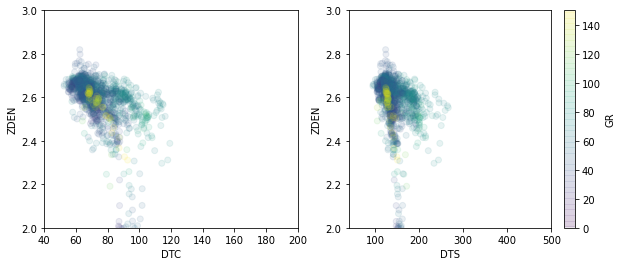

In [8]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter('DTC', 'ZDEN', data=train_well, alpha=0.1,
           c = 'GR', vmin = 0, vmax= 150)
plt.xlabel('DTC')
plt.ylabel('ZDEN')
plt.axis([40,200, 2,3])

plt.subplot(122)
plt.scatter('DTS', 'ZDEN', data=train_well, alpha=0.1,
           c = 'GR', vmin = 0, vmax= 150)
plt.xlabel('DTS')
plt.ylabel('ZDEN')
plt.axis([40,500, 2,3])

cbar = plt.colorbar()
cbar.set_label('GR')

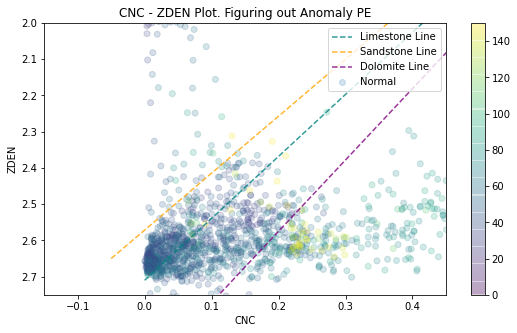

In [9]:
plt.figure(figsize=(9,5))
plt.title('CNC - ZDEN Plot. Figuring out Anomaly PE')
plt.scatter('CNC', 'ZDEN', data=train_well, alpha=0.2, 
            linewidths=None, label = 'Normal',
           c='GR', vmin = 0, vmax= 150)

plt.plot([0, 1],[2.71, 1], '--', color='teal', alpha =0.8, label = 'Limestone Line')
plt.plot([-0.05, 1],[2.65, 1], '--', color='orange', alpha =0.8, label = 'Sandstone Line')
plt.plot([0.05, 1],[2.87, 1], '--', color='purple', alpha =0.8, label = 'Dolomite Line')

plt.ylabel('ZDEN')
plt.xlabel('CNC')

plt.axis([-0.15,0.45,2,2.75])
plt.gca().invert_yaxis()
plt.legend()
plt.colorbar()

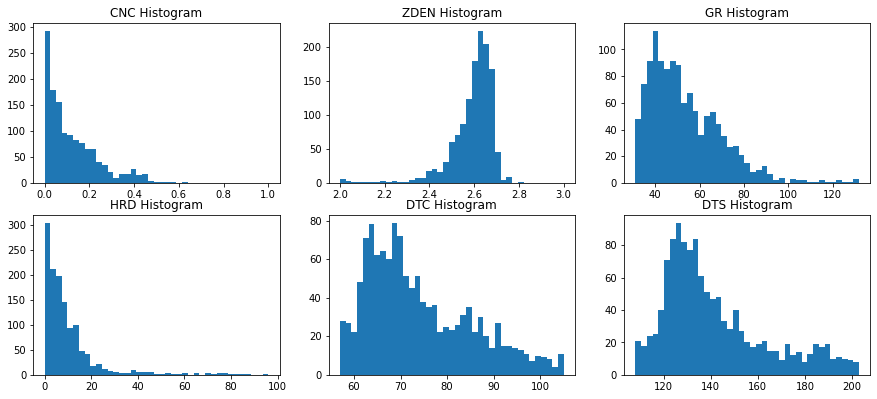

In [10]:
plot_hist_all()

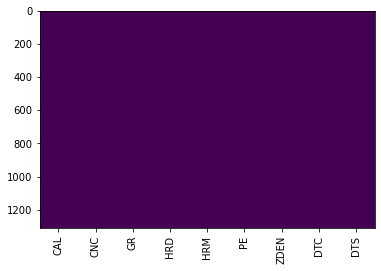

In [11]:
plt.imshow(train_well.isna(), aspect='auto')
plt.xticks(range(len(train_well.columns)), train_well.columns, rotation='vertical');


In [12]:
train_well.isna().sum()

CAL     0
CNC     0
GR      0
HRD     0
HRM     0
PE      0
ZDEN    0
DTC     0
DTS     0
dtype: int64

<BarContainer object of 7 artists>

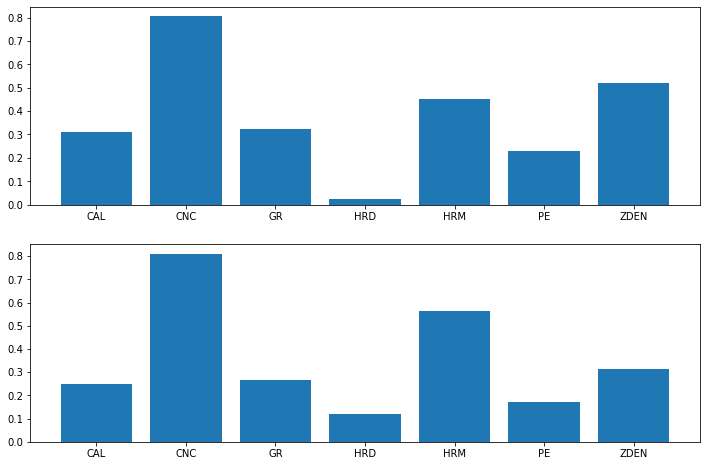

In [13]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.bar(train_well.corr()['DTC'].index[:-2], np.absolute(train_well.corr()['DTC'].values)[:-2])

plt.subplot(212)
plt.bar(train_well.corr()['DTS'].index[:-2], np.absolute(train_well.corr()['DTS'].values)[:-2])

In [14]:
# Feature engineering functions

def dphi(RHOB, rhoma = 2.65, rhofl = 1.1):
    if math.isnan(RHOB):
        return np.nan
    else:
        phi = (rhoma - RHOB) / (rhoma - rhofl)
        return phi

def water_lst_flag(phi_diff_lst, threshold = 0.015):
    if math.isnan(phi_diff_lst):
        return np.nan
    else:
        if phi_diff_lst < threshold:
            return 1
        else: 
            return 0
        
def hc_ind_flag(phi_diff_lst, threshold = 0.3):
    if math.isnan(phi_diff_lst):
        return np.nan
    else:
        if phi_diff_lst > threshold:
            return 1
        else: 
            return 0
        
def fluid_indicator(phi_diff_lst, threshold = 0.3):
    if math.isnan(phi_diff_lst):
        return np.nan
    else:
        if phi_diff_lst > threshold:
            return 'HC'
        else: 
            return 'Water'
        
    
def borehole_size(cal):
    dist_to_1225 = abs(cal - 12.25) # can be written using zip
    dist_to_85 = abs(cal - 8.5)
    dist_to_6 = abs(cal - 6)
    
    if (dist_to_1225 < dist_to_85) and (dist_to_1225 < dist_to_6):
        return 12.25
    elif (dist_to_85 < dist_to_1225) and (dist_to_85 < dist_to_6):
        return 8.5
    elif (dist_to_6 < dist_to_1225) and (dist_to_6 < dist_to_85):
        return 6
    else:
        return np.nan
    
def hole_qc_flag(hole_diff):
    if hole_diff > 0:
        return 'Washout'
    elif hole_diff <= 0: 
        return 'Mudcake'
    else:
        return np.nan
    
def dist_2d(line_start, line_end, point):
    """
    Determine distance between a point to a line marked by starting point and ending point
    Used in litho_chart() function
    """
    line_start = np.asarray(line_start)
    line_end = np.asarray(line_end)
    point = np.asarray(point)
    
    d = linalg.norm(np.cross(line_end-line_start, line_start-point))/linalg.norm(line_end-line_start)
    return d

def litho_chart(NPHI, RHOB, GR, p90):
    """
    Determine a (NPHI, RHOB) point distance towards a CP-1b matrix line
    Return the lithology based on the shortest distance
    Crossplot ref: https://wiki.aapg.org/File:Predicting-reservoir-system-quality-and-performance_fig9-31.png
    Matrix DTC ref:
    - Reservoir:
    https://www.uio.no/studier/emner/matnat/geofag/GEO4250/v08/undervisningsmateriale/Lectures/BWLA%20-%20Porosity%20Logs.pdf 
    using us/ft
    - Shale: https://www.spec2000.net/13-lithdn.htm using us/ft in kaolinite
    
    TODO: 
    - use equation instead of 2 lines (to capture dolomite nonlinearity). 
    - add more lithology line
    - automate the percentile calculation
    """
    if math.isnan(NPHI) or math.isnan(RHOB) or math.isnan(GR):
        return np.nan
    elif GR >= p90:
        return 'Shale'
    else:
        sst_line_start = (-0.02, 2.65)
        sst_line_end = (0.35, 2)

        lst_line_start = (0, 2.71)
        lst_line_end = (0.4, 2)

        dol_line_start = (0.02, 2.87)
        dol_line_end = (0.43, 2.14)

        dist_to_sst = dist_2d(sst_line_start, sst_line_end, (NPHI, RHOB))
        dist_to_lst = dist_2d(lst_line_start, lst_line_end, (NPHI, RHOB))
        dist_to_dol = dist_2d(dol_line_start, dol_line_end, (NPHI, RHOB))
        
        if dist_to_sst < dist_to_lst and dist_to_sst < dist_to_dol:
#             return 182
#             return 55.5
            return 'Sandstone'
        elif dist_to_lst < dist_to_sst and dist_to_lst < dist_to_dol:
#             return 155
#             return 47.5
            return 'Limestone'
        elif dist_to_dol < dist_to_sst and dist_to_dol < dist_to_lst:
        #             return 144
#             return 43.5
            return 'Dolomite'
        else:
            return np.nan

def deep_res_check(deep_res, mid_res):
    if math.isnan(deep_res) or math.isnan(mid_res):
        return np.nan
    else:
        if np.log10(deep_res) > 3 * np.log10(mid_res):
            return 1
        else:
            return 0
    
# Define error measure for official scoring : RMSE
def rmse_cv(model, x, y):
    scorer = make_scorer(mean_squared_error, greater_is_better = False)
    rmse= np.sqrt(-cross_val_score(model, x, y, scoring = scorer, cv = 10))
    return(rmse)

def rolling_NDI(df, curve, window = 500, perc_min = 0.03, perc_max = 0.97):
    """
    Auto VShale calculator with rolling window.
    """
    log = df[curve]
    length = len(log)
    NDI = []
    for index, reading in enumerate(log):
        if (index > window) & (index < length - window):
            perc_interval = log[index - window : index + window]
            
            grma = np.quantile(perc_interval, perc_min)
            grsh = np.quantile(perc_interval, perc_max)
            
            NDI.append((reading - grma) / (grsh - grma))
            
        elif (index<window):
            perc_interval = log[0 : index + window]
            
            grma = np.quantile(perc_interval, perc_min)
            grsh = np.quantile(perc_interval, perc_max)
            
            NDI.append((reading - grma) / (grsh - grma))
        
        elif (index>window):
            perc_interval = log[index - window : length]
            
            grma = np.quantile(perc_interval, perc_min)
            grsh = np.quantile(perc_interval, perc_max)
            
            NDI.append((reading - grma) / (grsh - grma))
            
        else:
            NDI.append(np.nan)
    
    df[curve + '_NDI'] = NDI
    
    return df

# well data prep wrapper function
def prepare_well(loaded_well):
    # feature engineering
    loaded_well['borehole_sz'] = loaded_well.apply(lambda df: borehole_size(df.CAL), axis = 1)
    loaded_well['hole_diff'] = loaded_well['CAL'] - loaded_well['borehole_sz']
    loaded_well['hole_qc'] = loaded_well.apply(lambda df: hole_qc_flag(df.hole_diff), axis = 1)
    loaded_well['phid_lst'] = loaded_well.apply(lambda df: dphi(df.ZDEN, rhoma = 2.71), axis = 1)
    loaded_well['phi_diff_lst'] = abs(loaded_well['CNC'] - loaded_well['phid_lst'])
    loaded_well['is_water_lst'] = loaded_well.apply(lambda df: water_lst_flag(df.phi_diff_lst), axis = 1)
    loaded_well['fluid'] = loaded_well.apply(lambda df:fluid_indicator(df.phi_diff_lst, threshold = 0.3), axis = 1)

    loaded_well['is_hc_ind'] = loaded_well.apply(lambda df: hc_ind_flag(df.phi_diff_lst), axis = 1)
    loaded_well['is_deep_res_higher'] = loaded_well.apply(lambda df: deep_res_check(deep_res = df.HRD, mid_res = df.HRM), axis = 1)
    loaded_well['lithology'] = loaded_well.apply(lambda df: litho_chart(NPHI = df.CNC, RHOB = df.ZDEN, GR = df.GR, p90 = 90), axis = 1)
    
    # categorical data encoding
    litho_dict = {'Shale' : 211,
                 'Sandstone' : 182,
                 'Limestone' : 153,
                 'Dolomite' : 144}
    loaded_well['litho_ord'] = loaded_well.lithology.map(litho_dict)

    hole_qc_dict = {'Washout' : 1, 
                    'Mudcake' : 2} 
    loaded_well['hole_qc_ord'] = loaded_well.hole_qc.map(hole_qc_dict)
    
    # log transform
    log_trf = ['CAL', 'CNC', 'GR', 'HRD', 'HRM', 'PE', 
               'ZDEN', 'borehole_sz', 'hole_diff', 'phid_lst', 
               'phi_diff_lst', 'litho_ord', 'hole_qc_ord']
    
    loaded_well = rolling_NDI(loaded_well, curve= 'GR', 
                         window=250, 
                         perc_max=0.97, 
                         perc_min=0.03)
    

    for log in log_trf:
        loaded_well[log + '_log'] = np.log1p(loaded_well[log])
    
    
    
    return loaded_well

In [15]:
train_well = prepare_well(pd.read_csv('train1.csv').replace(-999.0000, np.nan)).dropna()
train_well['DTC_log'] = np.log1p(train_well['DTC'])
train_well['DTS_log'] = np.log1p(train_well['DTS'])

test_well = prepare_well(pd.read_csv('test1.csv').replace(-999.0000, np.nan))

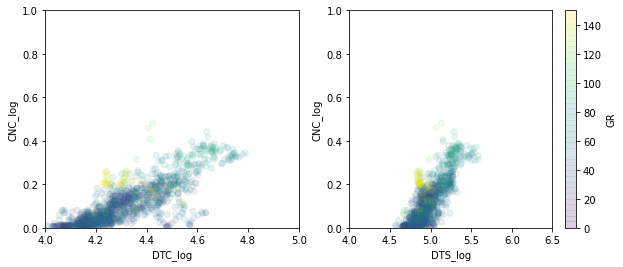

In [16]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter('DTC_log', 'CNC_log', data=train_well, alpha=0.1,
           c = 'GR', vmin = 0, vmax= 150)
plt.xlabel('DTC_log')
plt.ylabel('CNC_log')
plt.axis([4,5, 0,1])

plt.subplot(122)
plt.scatter('DTS_log', 'CNC_log', data=train_well, alpha=0.1,
           c = 'GR', vmin = 0, vmax= 150)
plt.xlabel('DTS_log')
plt.ylabel('CNC_log')
plt.axis([4,6.5, 0,1])

cbar = plt.colorbar()
cbar.set_label('GR')

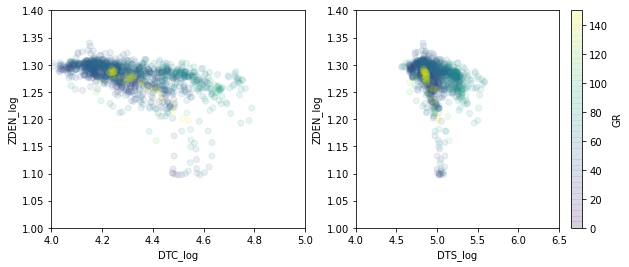

In [17]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter('DTC_log', 'ZDEN_log', data=train_well, alpha=0.1,
           c = 'GR', vmin = 0, vmax= 150)
plt.xlabel('DTC_log')
plt.ylabel('ZDEN_log')
plt.axis([4,5, 1,1.4])

plt.subplot(122)
plt.scatter('DTS_log', 'ZDEN_log', data=train_well, alpha=0.1,
           c = 'GR', vmin = 0, vmax= 150)
plt.xlabel('DTS_log')
plt.ylabel('ZDEN_log')
plt.axis([4,6.5, 1,1.4])

cbar = plt.colorbar()
cbar.set_label('GR')


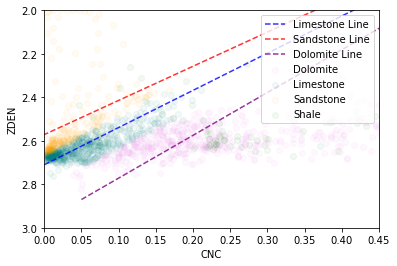

In [18]:
color = ['violet', 'teal', 'orange', 'green']
for i,j in enumerate(train_well.lithology.unique()):
    temp = train_well[train_well.lithology == j]
    plt.scatter('CNC', 'ZDEN', data = temp, alpha = 0.05, 
                label = j, c = color[i])
    

    
plt.plot([0, 1],[2.71, 1], '--', color='blue', alpha =0.8, label = 'Limestone Line')
plt.plot([-0.05, 1],[2.65, 1], '--', color='red', alpha =0.8, label = 'Sandstone Line')
plt.plot([0.05, 1],[2.87, 1], '--', color='purple', alpha =0.8, label = 'Dolomite Line')

plt.ylabel('ZDEN')
plt.xlabel('CNC')

plt.axis([0,0.45,3,2])
plt.legend()

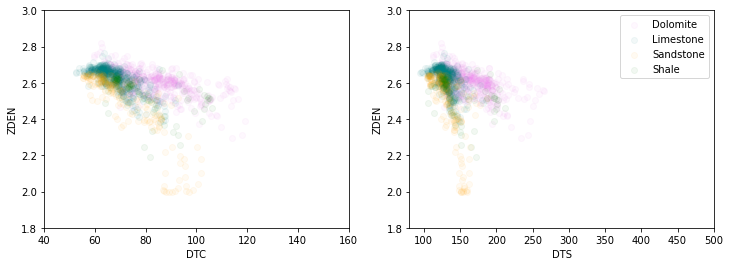

In [19]:
color = ['violet', 'teal', 'orange', 'green']
plt.figure(figsize=(12,4))
plt.subplot(121)
for i,j in enumerate(train_well.lithology.unique()):
    temp = train_well[train_well.lithology == j]
    plt.scatter('DTC', 'ZDEN', data = temp, alpha = 0.05, 
                label = j, c = color[i])

    
plt.axis([40,160, 1.8, 3])

plt.xlabel('DTC')
plt.ylabel('ZDEN')

plt.subplot(122)
for i,j in enumerate(train_well.lithology.unique()):
    temp = train_well[train_well.lithology == j]
    plt.scatter('DTS', 'ZDEN', data = temp, alpha = 0.05, 
                label = j, c = color[i])

plt.axis([80,500, 1.8, 3])

plt.xlabel('DTS')
plt.ylabel('ZDEN')
    
plt.legend()

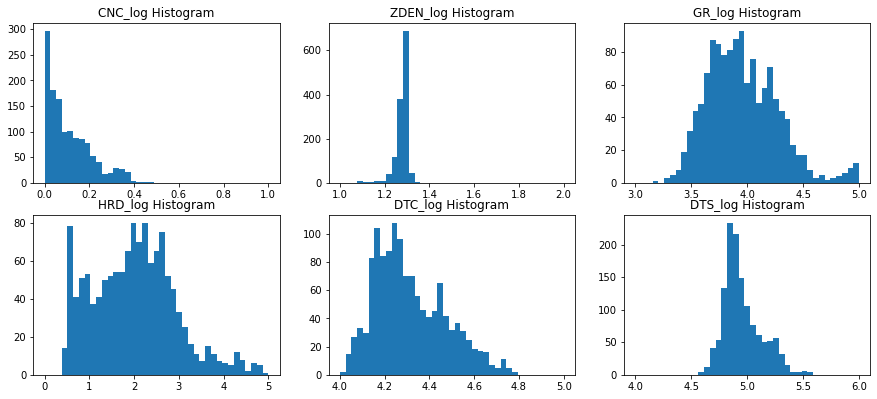

In [20]:
plot_hist_all(log=True)

In [21]:
X_train, X_val, y_train, y_val = train_test_split(train_well.dropna().drop(['DTC', 'DTS', 'DTC_log', 'DTS_log'], axis = 1), 
                                                  train_well.dropna()[['DTC', 'DTS', 'DTC_log', 'DTS_log']], 
                                                  test_size = 0.2, 
                                                  random_state = 123)

In [22]:
'''General Training and Scoring Function'''

def train_it(model_dtc, model_dts, X_train,  y_train, plot = False):
    
#     X_train = pd.get_dummies(X_train)
    try:
         model_dtc.fit(X_train, y_train['DTC_log'], verbose=0)
    except:
         model_dtc.fit(X_train, y_train['DTC_log'])
            
    cols = list(X_train.columns)
    
    
    '''==========MODELLING DTC'''
    
    print('DTC ==== on log scale')
    print("RMSE on Training set:", np.sqrt(mean_squared_error((model_dtc.predict(X_train[cols])), 
                                                              y_train['DTC_log'])),'\n',
          "RMSE on test set:", np.sqrt(mean_squared_error((model_dtc.predict(X_val[cols])), 
                                                          y_val['DTC_log'])))
  
    
    dtc_score_train = np.sqrt(mean_squared_error(np.expm1(model_dtc.predict(X_train[cols])), 
                                                 y_train['DTC']))
    dtc_score_val =   np.sqrt(mean_squared_error(np.expm1(model_dtc.predict(X_val  [cols])), 
                                                 y_val  ['DTC']))
    
    print('DTC ==== on normal scale')
    print("RMSE on Training set:", dtc_score_train ,'\n',
          "RMSE on test set:", dtc_score_val ,'\n',
         )
    
    if plot==True:
        plt.figure(figsize=(10,5))

        plt.subplot(1,2,1)
        plt.title('DTC Pred')
        plt.xlabel('pred DTC')
        plt.ylabel('true DTC')
        plt.scatter(np.expm1(model_dtc.predict(X_train[cols])), y_train['DTC'], 
                    c='red', linewidths= 0,alpha = 0.005, label = 'Train Predict')
        plt.scatter(np.expm1(model_dtc.predict(X_val[cols])), y_val['DTC'], 
                    c='blue', linewidths= 0,alpha = 0.005, label = 'Val Predict')

        plt.plot([40, 140],[40, 140], c='black')
        plt.axis([40, 140, 40, 140])
    else:
        pass
    
    
    out_model_dtc = model_dtc

    
    '''==========MODELLING DTS'''
    
    try:
        model_dts.fit(X_train, y_train['DTS_log'], verbose=0)
    except:
        model_dts.fit(X_train, y_train['DTS_log'])
        
    
    print('DTS ==== on log scale')
    print("RMSE on Training set:", np.sqrt(mean_squared_error((model_dts.predict(X_train[cols])), y_train['DTS_log'])),'\n',
          "RMSE on test set:", np.sqrt(mean_squared_error((model_dts.predict(X_val[cols])), y_val['DTS_log'])),'\n',

         )
    
    dts_score_train = np.sqrt(mean_squared_error(np.expm1(model_dts.predict(X_train[cols])), y_train['DTS']))
    dts_score_val = np.sqrt(mean_squared_error(np.expm1(model_dts.predict(X_val[cols])), y_val['DTS']))

    
    print('DTS ==== on normal scale')
    print("RMSE on Training set:", dts_score_train,'\n',
          "RMSE on test set:", dts_score_val,'\n',
         )
    
    
    if plot==True:

        plt.subplot(1,2,2)
        plt.title('DTS Pred')
        plt.xlabel('pred DTS')
        plt.ylabel('true DTS')
        plt.scatter(np.expm1(model_dts.predict(X_train[cols])), y_train['DTS'],
                    c='red', linewidths= 0,alpha = 0.005, label = 'Train Predict')

        plt.scatter(np.expm1(model_dts.predict(X_val[cols])), y_val['DTS'],
                    c='blue', linewidths= 0,alpha = 0.005, label = 'Val Predict')
        plt.plot([50, 350],[50, 350], c='black')
        plt.axis([50,350,50,350])
    else:
        pass

    
    out_model_dts = model_dts

    return [dtc_score_train, dtc_score_val], [dts_score_train, dts_score_val], out_model_dtc, out_model_dts, cols

In [23]:
'''Helper for Scoring Function'''

def score_summary_append(dtc_score, dts_score, dtc_model, dts_model, col, comment=''):
    global score_summary    

        
    if str(type(dtc_model)) == "<class 'sklearn.pipeline.Pipeline'>":
        temp_dtc = str(dtc_model.steps)
        
    elif str(type(dtc_model)) == 'sklearn.model_selection._search.GridSearchCV':
        temp_dtc = str(dtc_model.best_estimator_.steps)
        
    else:
        temp_dtc = str(dtc_model)
        
        
        
    if str(type(dts_model)) == "<class 'sklearn.pipeline.Pipeline'>":
        temp_dts = str(dts_model.steps)
        
    elif str(type(dts_model)) == 'sklearn.model_selection._search.GridSearchCV':
        temp_dtc = str(dtc_model.best_estimator_.steps)
    else:
        temp_dts = str(dts_model)


    temp = {'training_features':[col],
            
            'dtc_model':str(temp_dtc),
            'dtc_train_score':dtc_score[0],
            'dtc_val_score':dtc_score[1],
            
            'dts_model':str(temp_dts),
            'dts_train_score':dts_score[0],
            'dts_val_score':dts_score[1],
            'comment': comment
           }
    score_summary = score_summary.append(pd.DataFrame(temp), ignore_index = True)
    score_summary = score_summary.drop_duplicates(subset=['dtc_model', 'dts_model', 'dtc_train_score','dts_train_score'])


In [24]:
'''Scoring Matrix for Every Model Tried'''
score_summary = pd.DataFrame(columns=['training_features',
                                      'dtc_model','dtc_train_score','dtc_val_score',
                                      'dts_model','dts_train_score','dts_val_score',
                                      'comment'])

In [25]:
'''Reg Var being used to control which Featrures Should be used for Training'''
reg_var = ['ZDEN_log', 
           'CNC_log', 
           'CAL_log', 
           'HRD_log', 
           'HRM_log', 
           'GR_log', 
           'PE_log', 
           'borehole_sz_log', 
           'hole_diff_log', 
           'phid_lst_log', 
           'phi_diff_lst_log', 
           'hole_qc_ord_log',
           'is_deep_res_higher',]

DTC ==== on log scale
RMSE on Training set: 0.05749912208066234 
 RMSE on test set: 0.05764559222757368
DTC ==== on normal scale
RMSE on Training set: 4.692932068163476 
 RMSE on test set: 4.651124671985796 

DTS ==== on log scale
RMSE on Training set: 0.0716102885218053 
 RMSE on test set: 0.07636831400109441 

DTS ==== on normal scale
RMSE on Training set: 11.691735948788878 
 RMSE on test set: 12.091035762718843 



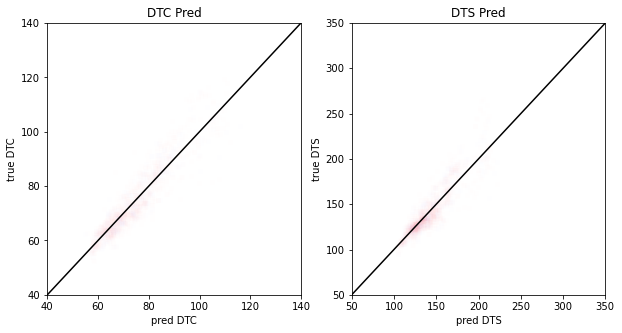

In [26]:
lr = LinearRegression()

dtc_score, dts_score, dtc_model, dts_model, col = train_it(lr,lr, X_train[reg_var], y_train, plot=True)
score_summary_append(dtc_score, dts_score, dtc_model, dts_model, col, comment='Base: LR')

In [27]:
'''Add Polynomial Features using Pipeline'''

lasso = Lasso()

dtc_score, dts_score, dtc_model, dts_model, col = train_it(lasso,lasso, X_train[reg_var], y_train)
score_summary_append(dtc_score, dts_score, dtc_model, dts_model, col, comment='Base: Lasso')

DTC ==== on log scale
RMSE on Training set: 0.1581705941530974 
 RMSE on test set: 0.16224495783758042
DTC ==== on normal scale
RMSE on Training set: 12.619944235335502 
 RMSE on test set: 12.935218795481394 

DTS ==== on log scale
RMSE on Training set: 0.17062608919422156 
 RMSE on test set: 0.1740417769370419 

DTS ==== on normal scale
RMSE on Training set: 26.849784730338627 
 RMSE on test set: 27.218631291774205 



In [28]:
'''Add Polynomial Features using Pipeline'''

ridge = Ridge()

dtc_score, dts_score, dtc_model, dts_model, col = train_it(ridge,ridge, X_train[reg_var], y_train)
score_summary_append(dtc_score, dts_score, dtc_model, dts_model, col, comment='Base: Ridge')

DTC ==== on log scale
RMSE on Training set: 0.05968250806822333 
 RMSE on test set: 0.05996589509273795
DTC ==== on normal scale
RMSE on Training set: 4.882225360170105 
 RMSE on test set: 4.816232617271908 

DTS ==== on log scale
RMSE on Training set: 0.07314490632966308 
 RMSE on test set: 0.07798396417770465 

DTS ==== on normal scale
RMSE on Training set: 11.971144982981803 
 RMSE on test set: 12.344617347479998 



In [29]:
RF = RandomForestRegressor()
poly = PolynomialFeatures(degree=2)
RF = Pipeline([('poly', poly),('model',RF)])

dtc_score, dts_score, dtc_model, dts_model, col = train_it(RF,RF, X_train[reg_var], y_train)
score_summary_append(dtc_score, dts_score, dtc_model, dts_model, col, comment='Base: RF')

DTC ==== on log scale
RMSE on Training set: 0.01708344095419761 
 RMSE on test set: 0.048018918011223745
DTC ==== on normal scale
RMSE on Training set: 1.3734112225577142 
 RMSE on test set: 3.835402914615089 

DTS ==== on log scale
RMSE on Training set: 0.021575743810069273 
 RMSE on test set: 0.05796452715304388 

DTS ==== on normal scale
RMSE on Training set: 3.4864300332563376 
 RMSE on test set: 8.96146306221345 



DTC ==== on log scale
RMSE on Training set: 6.61145568164617e-15 
 RMSE on test set: 0.044797515351269655
DTC ==== on normal scale
RMSE on Training set: 5.131653098735643e-13 
 RMSE on test set: 3.5629370948600974 

DTS ==== on log scale
RMSE on Training set: 7.615283709439033e-15 
 RMSE on test set: 0.05596982756719123 

DTS ==== on normal scale
RMSE on Training set: 1.1186377940348328e-12 
 RMSE on test set: 8.616243663536137 



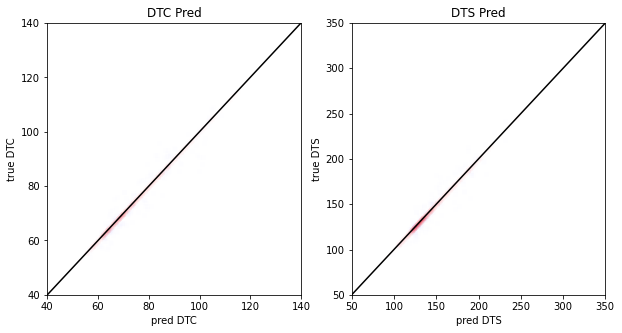

In [30]:
ET = ExtraTreesRegressor()
poly = PolynomialFeatures(degree=2)
ET = Pipeline([('poly', poly),('model',ET)])

dtc_score, dts_score, dtc_model, dts_model, col = train_it(ET,ET, X_train[reg_var], y_train, plot=True)
score_summary_append(dtc_score, dts_score, dtc_model, dts_model, col, comment='Base: ExtraTree')

In [31]:
ADA = AdaBoostRegressor()
poly = PolynomialFeatures(degree=2)
ADA = Pipeline([('poly', poly),('model',ADA)])

dtc_score, dts_score, dtc_model, dts_model, col = train_it(ADA,ADA, X_train[reg_var], y_train)
score_summary_append(dtc_score, dts_score, dtc_model, dts_model, col, comment='Base: ADA')

DTC ==== on log scale
RMSE on Training set: 0.04960303577453438 
 RMSE on test set: 0.058857599099586815
DTC ==== on normal scale
RMSE on Training set: 3.949535810365079 
 RMSE on test set: 4.671019355171633 

DTS ==== on log scale
RMSE on Training set: 0.05867692142742979 
 RMSE on test set: 0.07062567842928273 

DTS ==== on normal scale
RMSE on Training set: 8.976199841930972 
 RMSE on test set: 10.748901686831198 



In [32]:
XGB = xgboost.XGBRegressor()
poly = PolynomialFeatures(degree=2)
XGB = Pipeline([('poly', poly),('model',XGB)])

dtc_score, dts_score, dtc_model, dts_model, col = train_it(XGB,XGB, X_train[reg_var], y_train)
score_summary_append(dtc_score, dts_score, dtc_model, dts_model, col, comment='Base: XGBR')

DTC ==== on log scale
RMSE on Training set: 0.0015645705647449385 
 RMSE on test set: 0.05099423566865934
DTC ==== on normal scale
RMSE on Training set: 0.1210342891937205 
 RMSE on test set: 4.091631466199501 

DTS ==== on log scale
RMSE on Training set: 0.0017206403619840487 
 RMSE on test set: 0.058595280745925474 

DTS ==== on normal scale
RMSE on Training set: 0.2516078506180198 
 RMSE on test set: 8.973018457829074 



In [33]:
LGB = lgb.LGBMRegressor()
poly = PolynomialFeatures(degree=2)
LGB = Pipeline([('poly', poly),('model',LGB)])

dtc_score, dts_score, dtc_model, dts_model, col = train_it(LGB,LGB, X_train[reg_var], y_train, plot = False)
score_summary_append(dtc_score, dts_score, dtc_model, dts_model, col, comment='Base: LGBM')

DTC ==== on log scale
RMSE on Training set: 0.010654382423213808 
 RMSE on test set: 0.04812028820705848
DTC ==== on normal scale
RMSE on Training set: 0.8526065498292701 
 RMSE on test set: 3.89062135805754 

DTS ==== on log scale
RMSE on Training set: 0.013813144409864272 
 RMSE on test set: 0.05791460529202302 

DTS ==== on normal scale
RMSE on Training set: 2.2836473182337786 
 RMSE on test set: 9.094970666743174 



DTC ==== on log scale
RMSE on Training set: 0.010654382423213808 
 RMSE on test set: 0.04812028820705848
DTC ==== on normal scale
RMSE on Training set: 0.8526065498292701 
 RMSE on test set: 3.89062135805754 

DTS ==== on log scale
RMSE on Training set: 0.01266035997733336 
 RMSE on test set: 0.06119501484286626 

DTS ==== on normal scale
RMSE on Training set: 2.063141169296656 
 RMSE on test set: 9.662909763975469 



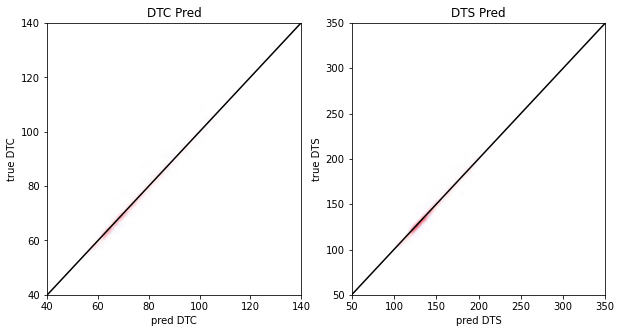

In [34]:
'''DTC Algorithm'''
dtc_ml = lgb.LGBMRegressor()
dtc_poly = PolynomialFeatures(degree=2)
dtc_pipe = Pipeline([('poly', dtc_poly),('model',dtc_ml)])

'''DTC Algorithm'''
dts_ml = lgb.LGBMRegressor()
dts_poly = PolynomialFeatures(degree=2)

'Adding data Scaler on DTS Prediction'
dts_scaler = Normalizer()
dts_pipe = Pipeline([('poly', dts_poly),('scaler',dts_scaler ),('model',dts_ml)])

dtc_score, dts_score, dtc_model, dts_model, col = train_it(dtc_pipe,dts_pipe, X_train[reg_var], y_train, plot=True)
score_summary_append(dtc_score, dts_score, dtc_model, dts_model, col, comment='DTC DTS split: LGBM')

In [35]:
reg_var = ['ZDEN_log', 
           'CNC_log', 
           'CAL_log', 
           'HRD_log', 
           'HRM_log', 
           'GR_log', 
           'PE_log', 
           'litho_ord_log', ]

dtc_score, dts_score, dtc_model_2, dts_model_2, col =  train_it(dtc_pipe,dts_pipe, X_train[reg_var], y_train)
score_summary_append(dtc_score, dts_score, dtc_model_2, dts_model_2, col, comment='DTC DTS split: LGBM, less feature')

DTC ==== on log scale
RMSE on Training set: 0.012119899951470834 
 RMSE on test set: 0.045513654056188346
DTC ==== on normal scale
RMSE on Training set: 0.9875982878292773 
 RMSE on test set: 3.6662181481040443 

DTS ==== on log scale
RMSE on Training set: 0.017014435388441104 
 RMSE on test set: 0.0664103780580036 

DTS ==== on normal scale
RMSE on Training set: 2.698613441183994 
 RMSE on test set: 10.31908143552477 



In [36]:
pred = pd.DataFrame()
pred['DTS'] = np.expm1(dts_model_2.predict(test_well[reg_var]))

In [37]:
def PHID_calc(rhob, rhoma, rhofl):
    phid = (rhoma - rhofl)/(rhob - rhofl)
    return phid

def PHIT_calc(phin, phid):
    phit = (phin + phid)/2
    if phit >0.00001:
        return phit
    else:
        return 0.00001

def PHIE_calc(phit, vsh, phish):
    phie = phit - (vsh*phish)
    if phie >0.00001:
        return phie
    else:
        return 0.00001

def SW_calc(phie,rt, rw, a=1, m=2, n=2, ):
    sw = np.power((a*rw) / (rt* np.power(phie,m)), 1/n)
    if sw>1:
        return 1
    elif sw<0:
        return 0.00001
    else:
        return sw

def RHOMA_calc(NPHI, RHOB, GR, p90):

    if math.isnan(NPHI) or math.isnan(RHOB) or math.isnan(GR):
        return np.nan
    elif GR >= p90:
        return 2.7
    else:
        sst_line_start = (-0.02, 2.65)
        sst_line_end = (0.35, 2)

        lst_line_start = (0, 2.71)
        lst_line_end = (0.4, 2)

        dol_line_start = (0.02, 2.87)
        dol_line_end = (0.43, 2.14)

        dist_to_sst = dist_2d(sst_line_start, sst_line_end, (NPHI, RHOB))
        dist_to_lst = dist_2d(lst_line_start, lst_line_end, (NPHI, RHOB))
        dist_to_dol = dist_2d(dol_line_start, dol_line_end, (NPHI, RHOB))
        
        if dist_to_sst < dist_to_lst and dist_to_sst < dist_to_dol:
            return 2.56
        elif dist_to_lst < dist_to_sst and dist_to_lst < dist_to_dol:
            return 2.71
        elif dist_to_dol < dist_to_sst and dist_to_dol < dist_to_lst:
            return 2.83
        else:
            return np.nan

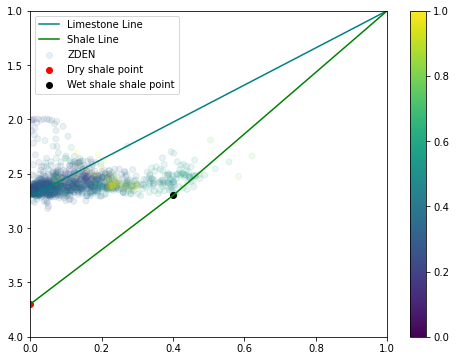

In [38]:
'''Parameter picking: Matrix Property'''
plt.figure(figsize=(8,6))
plt.scatter('CNC','ZDEN', data=train_well, alpha=0.1,
            c = 'GR', vmin = 0, vmax= 150)
plt.plot([1, 0],[1, 2.71], label = 'Limestone Line', c='teal')
plt.plot([1,0.4, 0],[1, 2.7, 3.7], label = 'Shale Line', c='green')
plt.scatter([0],[3.7], c= 'red', label = 'Dry shale point')
plt.scatter([0.4],[2.7], c= 'black', label = 'Wet shale shale point')

plt.legend()
plt.ylim(4,1)
plt.xlim(0,1)
plt.colorbar()

In [39]:
train_well['rhoma'] = train_well.apply(lambda df: RHOMA_calc(NPHI = df.CNC, RHOB = df.ZDEN, GR = df.GR, p90 = 90), axis = 1)
train_well['phid'] = train_well.apply(lambda df: PHID_calc(df.ZDEN, df.rhoma, rhofl=1.1), axis = 1)
train_well['phin'] = train_well['CNC']
train_well['phit'] = train_well.apply(lambda df: PHIT_calc(df.phid, df.phin), axis = 1)
train_well['phie'] = train_well.apply(lambda df: PHIE_calc(df.phit, df.GR_NDI, 0.4), axis = 1)

test_well['rhoma'] = test_well.apply(lambda df: RHOMA_calc(NPHI = df.CNC, RHOB = df.ZDEN, GR = df.GR, p90 = 90), axis = 1)
test_well['phid'] = test_well.apply(lambda df: PHID_calc(df.ZDEN, df.rhoma, rhofl=1.1), axis = 1)
test_well['phin'] = test_well['CNC']
test_well['phit'] = test_well.apply(lambda df: PHIT_calc(df.phid, df.phin), axis = 1)
test_well['phie'] = test_well.apply(lambda df: PHIE_calc(df.phit, df.GR_NDI, 0.4), axis = 1)

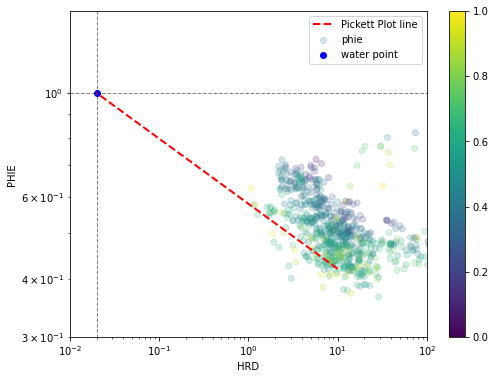

In [40]:
'''Parameter picking: Pickett Plot'''

plt.figure(figsize=(8,6))
plt.scatter('HRD','phie', data=train_well[train_well.GR_NDI <=0.3], c='GR_log', alpha=0.2)

plt.plot([0.01, 1000], [1,1], 
         c='black', alpha=0.5, linestyle = '--', linewidth=1)
plt.plot([0.02,0.02], [0.1, 1.5], 
         c='black', alpha=0.5, linestyle = '--', linewidth=1)

plt.plot([10, 0.02],[0.42,1], c = 'red', 
         linestyle = '--', linewidth=2, label='Pickett Plot line')

plt.scatter(0.02,1, c='blue', label = 'water point')

plt.ylim(0.3,1.5)
plt.xlim(0.01,100)

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.xlabel('HRD')
plt.ylabel('PHIE')
plt.colorbar()
plt.legend()

In [41]:
train_well['sw'] = train_well.apply(lambda df: SW_calc(df.phie,df.HRD, rw=0.02, a=1, m=2, n=2, ), axis = 1)
test_well['sw'] = test_well.apply(lambda df: SW_calc(df.phie,df.HRD, rw=0.02, a=1, m=2, n=2, ), axis = 1)

In [42]:
train_well['phid_log'] =np.log1p( train_well['phid'])
train_well['phin_log'] = np.log1p(train_well['phin'] )
train_well['phit_log'] = np.log1p(train_well['phit'])
train_well['phie_log'] = np.log1p(train_well['phie'])
train_well['sw_log'] = np.log1p(train_well['sw'])
# train_well['phie'] = train_well.apply(lambda df: PHIE_calc(df.phiE, df.GR_NDI, 0.4), axis = 1)

test_well['phid_log'] =np.log1p( test_well['phid'])
test_well['phin_log'] = np.log1p(test_well['phin'] )
test_well['phit_log'] = np.log1p(test_well['phit'])
test_well['phie_log'] = np.log1p(test_well['phie'])
test_well['sw_log'] = np.log1p(test_well['sw'])

In [43]:
train_well['GR_NPHI'] = np.log1p(train_well['GR'] / train_well['CNC'])
train_well['GR_RHOB'] = np.log1p(train_well['GR'] / train_well['ZDEN'])
train_well['NPHI_RHOB'] = np.log1p(train_well['CNC'] / train_well['ZDEN'])
train_well['NPHI_RT'] = np.log1p(train_well['CNC'] / train_well['HRD'])
train_well['RHOB_RT'] = np.log1p(train_well['ZDEN'] / train_well['HRD'])

test_well['GR_NPHI'] = np.log1p(test_well['GR'] / test_well['CNC'])
test_well['GR_RHOB'] = np.log1p(test_well['GR'] / test_well['ZDEN'])
test_well['NPHI_RHOB'] = np.log1p(test_well['CNC'] / test_well['ZDEN'])
test_well['NPHI_RT'] = np.log1p(test_well['CNC'] / test_well['HRD'])
test_well['RHOB_RT'] = np.log1p(test_well['ZDEN'] / test_well['HRD'])

C:\Users\Arushi Sinha\miniconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [44]:
X_train, X_val, y_train, y_val = train_test_split(train_well.dropna().drop(['DTC', 'DTS', 'DTC_log', 'DTS_log'], axis = 1), 
                                                  train_well.dropna()[['DTC', 'DTS', 'DTC_log', 'DTS_log']], 
                                                  test_size = 0.2, 
                                                  random_state = 123)

In [45]:
reg_var = ['ZDEN_log', 
           'CNC_log', 
           'CAL_log', 
           'HRD_log', 
           'HRM_log', 
           'GR_NDI', 
           'PE_log', 
           
           'litho_ord_log',
            'phit_log', 
            'phie_log',
            'sw_log']

In [46]:
'''DTC Algorithm'''
dtc_ml = lgb.LGBMRegressor()
dtc_poly = PolynomialFeatures(degree=2)
dtc_pipe = Pipeline([('poly', dtc_poly),('model',dtc_ml)])

'''DTC Algorithm'''
dts_ml = lgb.LGBMRegressor()
dts_poly = PolynomialFeatures(degree=2)
dts_scaler = Normalizer()
# dts_pipe = Pipeline([('poly', dts_poly),('model',dts_ml)])

dts_pipe = Pipeline([('poly', dts_poly),('scaler',dts_scaler ),('model',dts_ml)])

dtc_score, dts_score, dtc_lbgm_split_fe, dts_lbgm_split_fe, col =  train_it(dtc_pipe,dts_pipe, X_train[reg_var], y_train)
score_summary_append(dtc_score, dts_score, dtc_lbgm_split_fe, dts_lbgm_split_fe, col, comment='DTC DTS split + Petrophysic: LGBM')

DTC ==== on log scale
RMSE on Training set: 0.010605288658250575 
 RMSE on test set: 0.04730220809134224
DTC ==== on normal scale
RMSE on Training set: 0.8436563088754906 
 RMSE on test set: 3.8872854821214182 

DTS ==== on log scale
RMSE on Training set: 0.014960123533600598 
 RMSE on test set: 0.06433837280806906 

DTS ==== on normal scale
RMSE on Training set: 2.4291693489693396 
 RMSE on test set: 9.828248357229898 



In [47]:
reg_var = ['GR_NPHI', 'GR_RHOB', 'NPHI_RHOB',
           'NPHI_RT', 'RHOB_RT',
           
           'ZDEN_log', 
           'CNC_log', 
           'CAL_log', 
           'HRD_log', 
           'HRM_log', 
           'GR_NDI', 
           'PE_log', 
           
           'litho_ord_log',
            'phit_log', 
            'phie_log',
            'sw_log']

In [48]:
'''DTC Algorithm'''
dtc_ml = lgb.LGBMRegressor()
dtc_poly = PolynomialFeatures(degree=2)
dtc_pipe = Pipeline([('poly', dtc_poly),('model',dtc_ml)])

'''DTC Algorithm'''
dts_ml = lgb.LGBMRegressor()
dts_poly = PolynomialFeatures(degree=2)
dts_scaler = Normalizer()
# dts_pipe = Pipeline([('poly', dts_poly),('model',dts_ml)])

dts_pipe = Pipeline([('poly', dts_poly),('scaler',dts_scaler ),('model',dts_ml)])

dtc_score, dts_score, dtc_lbgm_split_fe, dts_lbgm_split_fe, col =  train_it(dtc_pipe,dts_pipe, X_train[reg_var], y_train)
score_summary_append(dtc_score, dts_score, dtc_lbgm_split_fe, dts_lbgm_split_fe, col, comment='DTC DTS split + Petrophysic + ratio: LGBM')

DTC ==== on log scale
RMSE on Training set: 0.009127405509823387 
 RMSE on test set: 0.04715196522854686
DTC ==== on normal scale
RMSE on Training set: 0.7268160182407459 
 RMSE on test set: 3.7862558976656855 

DTS ==== on log scale
RMSE on Training set: 0.013275079699116758 
 RMSE on test set: 0.06620378893337209 

DTS ==== on normal scale
RMSE on Training set: 2.2190143077990157 
 RMSE on test set: 10.305838317625172 



In [49]:
'''We reckon ther is one missing value, 
   thus we need to Fill the missing value on Test Dataset'''

test_well['GR_NDI'].fillna(value=test_well['GR_NDI'].mean(), inplace=True)

In [50]:
def train_stack_lvl1(model, reg_var, target, name):
    
    mla = model
    poly = PolynomialFeatures(degree=2)
    scaler = Normalizer()
    
    if target == 'DTS':
        pipe = Pipeline([('poly', poly),('scaler',scaler ),('model',mla)])    
    else:
        pipe = Pipeline([('poly', poly),('model',mla)])    

    pipe.fit(X_train[reg_var], y_train[target+'_log'] )
    
    print ('====== ',target, ' Lvl 1 Prediction')
    print ('====== Using MLA: ', name)
    print('RMSE Train: ',np.sqrt(mean_squared_error(np.expm1(pipe.predict(X_train[reg_var])), y_train[target])))
    print('RMSE val: ', np.sqrt(mean_squared_error(np.expm1(pipe.predict(X_val[reg_var])), y_val[target])))
    print('\n')
    
    train_pred = np.expm1(pipe.predict(X_train[reg_var]))

    output_pred = np.expm1(pipe.predict(test_well[reg_var]))

    val_pred = np.expm1(pipe.predict(X_val[reg_var]))
    
    return str(pipe), train_pred, val_pred, output_pred

def train_stack_lvl2(model_dict, reg_var):

    '''Modelling fot DTC'''

    to_train = 'DTC'

    pred_train = pd.DataFrame()
    pred_val = pd.DataFrame()
    pred_out_dtc = pd.DataFrame()

    for i in range(len(model_dict['name'])):
        model = model_dict['model'][i]
        name  = model_dict['name'][i]+'_'+to_train

        _, \
        pred_train[name], \
        pred_val[name], \
        pred_out_dtc[name] = train_stack_lvl1(model, reg_var, to_train, name)

    dtc_model = lgb.LGBMRegressor(random_state=123)
    reg_lv1 = list(pred_train.columns)
    dtc_model.fit(pred_train[reg_lv1], y_train[to_train])

    dtc_score_train = np.sqrt(mean_squared_error(dtc_model.predict(pred_train[reg_lv1]), y_train[to_train]))
    dtc_score_val = np.sqrt(mean_squared_error(dtc_model.predict(pred_val[reg_lv1]), y_val[to_train]))
    
    
    pred_train_dtc = pred_train
    pred_val_dtc = pred_val

    print ('======  DTC Lvl 2 Prediction')
    print ('feature used: ', reg_lv1)
    print ('train RMSE: ', dtc_score_train)
    print ('val RMSE: ', dtc_score_val)
    print ('================================\n\n')

    dtc_score = [dtc_score_train, dtc_score_val]

    '''Modelling fot DTS'''

    to_train = 'DTS'
    
    pred_train = pd.DataFrame()
    pred_val = pd.DataFrame()
    pred_out_dts = pd.DataFrame()

    for i in range(len(model_dict['name'])):
        model = model_dict['model'][i]
        name  = model_dict['name'][i]+'_'+to_train

        _, \
        pred_train[name], \
        pred_val[name], \
        pred_out_dts[name] = train_stack_lvl1(model, reg_var, to_train, name)

    dts_model = lgb.LGBMRegressor(random_state=123)
    reg_lv1 = list(pred_train.columns)
    dts_model.fit(pred_train[reg_lv1], y_train[to_train])

    dts_score_train = np.sqrt(mean_squared_error(dts_model.predict(pred_train[reg_lv1]), y_train[to_train]))
    dts_score_val = np.sqrt(mean_squared_error(dts_model.predict(pred_val[reg_lv1]), y_val[to_train]))
    
    pred_train_dts= pred_train
    pred_val_dts= pred_val
    
    print ('======  DTC Lvl 2 Prediction')
    print ('feature used: ', reg_lv1)
    print ('train RMSE: ', dtc_score_train)
    print ('val RMSE: ', dtc_score_val)
    print ('================================\n\n')

    dtc_score = [dtc_score_train, dtc_score_val]

    '''Modelling fot DTS'''

    to_train = 'DTS'
    
    pred_train = pd.DataFrame()
    pred_val = pd.DataFrame()
    pred_out_dts = pd.DataFrame()

    for i in range(len(model_dict['name'])):
        model = model_dict['model'][i]
        name  = model_dict['name'][i]+'_'+to_train

        _, \
        pred_train[name], \
        pred_val[name], \
        pred_out_dts[name] = train_stack_lvl1(model, reg_var, to_train, name)

    dts_model = lgb.LGBMRegressor(random_state=123)
    reg_lv1 = list(pred_train.columns)
    dts_model.fit(pred_train[reg_lv1], y_train[to_train])

    dts_score_train = np.sqrt(mean_squared_error(dts_model.predict(pred_train[reg_lv1]), y_train[to_train]))
    dts_score_val = np.sqrt(mean_squared_error(dts_model.predict(pred_val[reg_lv1]), y_val[to_train]))
    
    pred_train_dts= pred_train
    pred_val_dts= pred_val
    
    
    print ('======  DTS Lvl 2 Prediction')
    print ('feature used: ', reg_lv1)
    print ('train RMSE: ',dts_score_train)
    print ('val RMSE: ',dts_score_val)
    print ('================================')
    print ('================================\n\n\n')

    dts_score = [dts_score_train, dts_score_val]


    return  dtc_model, dts_model, \
            pred_train_dtc, pred_val_dtc, pred_out_dtc, \
            pred_train_dts, pred_val_dts, pred_out_dts,\
            dtc_score, dts_score

In [51]:
reg_var = ['ZDEN_log', 
           'CNC_log', 
           'CAL_log', 
           'HRD_log', 
           'HRM_log', 
           'GR_NDI', 
           'PE_log', 
           'litho_ord_log']

model_dict    = {'name' : [ 'LGBM', 'RF', 'GBR','ADA','EXTRA', 'LASSO', 'RIDGE', 'LR',],
                 'model': [lgb.LGBMRegressor(random_state=123),
                           RandomForestRegressor(random_state=123),
                           GradientBoostingRegressor(random_state=123),
                           AdaBoostRegressor(random_state=123),
                           ExtraTreesRegressor(random_state=123),
                           Lasso(random_state=123),
                           Ridge(random_state=123),
                           LinearRegression(),]}


dtc_model, dts_model,  \
pred_train_dtc, pred_val_dtc, pred_out_dtc, \
pred_train_dts, pred_val_dts, pred_out_dts,\
dtc_score, dts_score = train_stack_lvl2(model_dict,reg_var)


score_summary_append(dtc_score, dts_score, 
                     dtc_model, dts_model, 
                     reg_var, comment='Model Stacking: Basic log')

======  DTC  Lvl 1 Prediction
====== Using MLA:  LGBM_DTC
RMSE Train:  1.0232088307803784
RMSE val:  3.8099925652873496


======  DTC  Lvl 1 Prediction
====== Using MLA:  RF_DTC
RMSE Train:  1.3728391668956927
RMSE val:  3.6819891363789017


======  DTC  Lvl 1 Prediction
====== Using MLA:  GBR_DTC
RMSE Train:  2.661391859809576
RMSE val:  3.9407836405749603


======  DTC  Lvl 1 Prediction
====== Using MLA:  ADA_DTC
RMSE Train:  4.117793822157227
RMSE val:  4.557953113382998


======  DTC  Lvl 1 Prediction
====== Using MLA:  EXTRA_DTC
RMSE Train:  5.131653098735643e-13
RMSE val:  3.765331296005566


======  DTC  Lvl 1 Prediction
====== Using MLA:  LASSO_DTC
RMSE Train:  12.619944235335502
RMSE val:  12.935218795481394


======  DTC  Lvl 1 Prediction
====== Using MLA:  RIDGE_DTC
RMSE Train:  4.629189119229244
RMSE val:  4.651458148270755


======  DTC  Lvl 1 Prediction
====== Using MLA:  LR_DTC
RMSE Train:  4.163097674219709
RMSE val:  4.283778336902906


======  DTC Lvl 2 Prediction
fea

In [52]:
reg_var = ['ZDEN_log', 
           'CNC_log', 
           'CAL_log', 
           'HRD_log', 
           'HRM_log', 
           'GR_NDI', 
           'PE_log', 
           'litho_ord_log',
           
           'phit_log', 
           'phie_log',
           'sw_log']

model_dict    = {'name' : [ 'LGBM', 'RF', 'GBR','ADA','EXTRA', 'LASSO', 'RIDGE', 'LR',],
                 'model': [lgb.LGBMRegressor(random_state=123),
                           RandomForestRegressor(random_state=123),
                           GradientBoostingRegressor(random_state=123),
                           AdaBoostRegressor(random_state=123),
                           ExtraTreesRegressor(random_state=123),
                           Lasso(random_state=123),
                           Ridge(random_state=123),
                           LinearRegression(),]}


dtc_model, dts_model,  \
pred_train_dtc, pred_val_dtc, pred_out_dtc, \
pred_train_dts, pred_val_dts, pred_out_dts,\
dtc_score, dts_score = train_stack_lvl2(model_dict,reg_var)
                
score_summary_append(dtc_score, dts_score, 
                     dtc_model, dts_model, 
                     reg_var, comment='Model Stacking: Basic log + Petrophysic')

======  DTC  Lvl 1 Prediction
====== Using MLA:  LGBM_DTC
RMSE Train:  0.8436563088754906
RMSE val:  3.8872854821214182


======  DTC  Lvl 1 Prediction
====== Using MLA:  RF_DTC
RMSE Train:  1.3987809866235765
RMSE val:  3.863530420954652


======  DTC  Lvl 1 Prediction
====== Using MLA:  GBR_DTC
RMSE Train:  2.435758808429156
RMSE val:  3.9913030709021777


======  DTC  Lvl 1 Prediction
====== Using MLA:  ADA_DTC
RMSE Train:  4.011078274401942
RMSE val:  4.639884886781452


======  DTC  Lvl 1 Prediction
====== Using MLA:  EXTRA_DTC
RMSE Train:  5.131653098735643e-13
RMSE val:  3.8278379216115903


======  DTC  Lvl 1 Prediction
====== Using MLA:  LASSO_DTC
RMSE Train:  12.619944235335502
RMSE val:  12.935218795481394


======  DTC  Lvl 1 Prediction
====== Using MLA:  RIDGE_DTC
RMSE Train:  4.543045394824586
RMSE val:  4.587554934898023


======  DTC  Lvl 1 Prediction
====== Using MLA:  LR_DTC
RMSE Train:  3.7829350960936123
RMSE val:  4.340958606254612


======  DTC Lvl 2 Prediction
fe

In [53]:
pred['DTC'] = dtc_model.predict(pred_out_dtc)

In [54]:
pred[['DTC', 'DTS']]

,DTC,DTS
0,84.719509,148.211840
1,81.608278,141.840611
2,88.259956,153.000808
3,89.169899,151.522538
4,90.680619,155.120864
...,...,...
1506,68.927773,141.907768
1507,68.975978,141.907768
1508,70.111528,141.907768
1509,69.954306,141.907768


In [55]:
pred[['DTC','DTS']].to_csv(path_or_buf='./chmod 753 result.csv', index=False)